# Polars Example
This is a little example using the `nu_plugin_polars` to showcase that you can use dataframes pretty well with this kernel. The `nu_plugin_polars` is based on the dataframe libray [Polars](https://polar.rs), it is completely written in Rust (just like this kernel) and executes dataframes way faster that [Pandas](https://pandas.pydata.org), but do consider that we loose some performance in form of communication from your jupyter client, to the kernel, to the plugin and all the way back. It should be still fast to use.

To start using the plugin, you need to have it installed, this can easily be done via `cargo install nu_plugin_polars` on a machine that has the full Rust toolchain installed. Then you need to add the plugin to your plugin registry, if you have `nushell` installed (I guess so, because you are using this kernel), you simply run `plugin add <absolute-path-to-your-plugin>`, this will add it to your plugin registry and this kernel will be able to pick it up. If you don't have `nushell` on your machine (kinda weird, not gonna lie), you can also run the `plugin add` command in a notebook, for further help try to run `plugin --help` or check the [Plugins section](https://www.nushell.sh/book/plugins.html) on the nushell website.

Plugins in `nushell` are automatically loaded from your registry when you open the shell. However, for this kernel they need to be loaded manually, this ensures that other users of your notebook understand where some of the commands you're using are coming from.

In [1]:
# load the `polars` plugin to use its commands
plugin use polars

You also need some data for this notebook. This is using the [New Zealand business demography](https://www.stats.govt.nz/assets/Uploads/New-Zealand-business-demography-statistics/New-Zealand-business-demography-statistics-At-February-2020/Download-data/Geographic-units-by-industry-and-statistical-area-2000-2020-descending-order-CSV.zip) dataset. You can load it via the adjacent `polars-data.nu` file. If that run succesfully you should see in the `ls data` output the file `Data7602DescendingYearOrder.csv`.

In [2]:
ls data | nuju display md

|name|type|size|modified|
|-|-|-|-|
|data\Data7602DescendingYearOrder.csv|file|129.3 MiB|Wed, 5 Oct 2022 14:44:48 +0200 (2 years ago)|
|data\Metadata for Data7602DescendingYearOrder.xlsx|file|106.1 KiB|Thu, 20 Oct 2022 10:41:12 +0200 (2 years ago)|
|data\nz-stats.zip|file|22.9 MiB|Wed, 15 May 2024 12:30:31 +0200 (4 months ago)|

Ok, then let's load the csv file and check that the plugin loaded it.

In [3]:
let df = polars open data/Data7602DescendingYearOrder.csv
polars store-ls | nuju display md

|key|created|columns|rows|type|estimated_size|span_contents|span_start|span_end|reference_count|
|-|-|-|-|-|-|-|-|-|-|
|208664bf-188b-4d93-9079-1eae3d7a6811|Fri, 27 Sep 2024 13:26:24 +0200 (now)|5|5985364|LazyFrame|194.0 MiB|polars open|6394|6405|1|


We can also check the shape and schema of the dataset.

In [4]:
$df | polars shape | nuju print
$df | polars schema | nuju print

index: 0, rows: 5985364, columns: 5

anzsic06,Area,year,geo_count,ec_count
str,str,i64,i64,i64


And let's get a sample of the dataset.

In [5]:
$df | polars sample -n 5 | polars into-nu | nuju display md

|anzsic06|Area|year|geo_count|ec_count|
|-|-|-|-|-|
|S942|A183400|2014|3|0|
|E322|A140700|2001|3|0|
|J59|R13|2007|57|270|
|C20|A346700|2014|0|6|
|E30|A255000|2002|0|18|

And finally do some data operations on the dataset. We group the data by year, sum up the geo_count column and sort it by year. We convert the data into a `nu` object and pipe it to a `series bar` to create a nice bar chart.

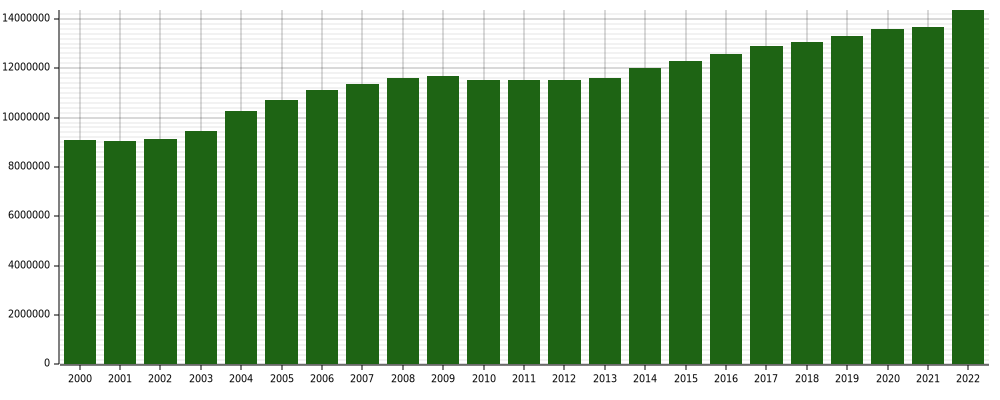

In [6]:
$df 
| polars group-by year 
| polars agg (polars col geo_count | polars sum)
| polars sort-by year 
| polars into-nu
| rename x y
| series bar -c [30, 100, 20]
| chart 2d -W 1000 -m [10, 10, 0, 25]
| nuju display svg